In [60]:
import os
import cv2
import numpy as np
import random
from itertools import combinations
import matplotlib.pyplot as plt

In [61]:
# Fijar semilla
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
IMG_SIZE = (200, 150)  # Ancho x alto
DATASET_DIR = "./resources"  # Cambia esta ruta si es necesario

In [63]:
"""
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMGREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalizar
    img = np.expand_dims(img, axis=-1)  # Canal adicional
    return img
""""""

In [ ]:
def load_dataset(dataset_dir, size=(IMG_SIZE)):
    data = []
    labels = []

    person_dirs = sorted(os.listdir(dataset_dir))
    
    for idx, person in enumerate(person_dirs):
        person_path = os.path.join(dataset_dir, person)
        if os.path.isdir(person_path):
            images = []
            for fname in os.listdir(person_path):
                try:
                    fpath = os.path.join(person_path, fname)
                    
                    # Cargar en escala de grises
                    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        raise Exception("Imagen no válida")

                    # Redimensionar al tamaño deseado
                    img = cv2.resize(img, size)

                    # Normalizar (opcional, también puedes hacerlo después)
                    img = img / 255.0
                    
                    images.append((img, idx, person))  # img, índice, nombre
                except Exception as e:
                    print(f"Error cargando {fpath}: {e}")
            if len(images) >= 2:
                data.append(images)
    return data


In [ ]:
def generate_pairs(data, num_negatives_per_positive=1):
    pairs = []
    labels = []
    meta_info = []

    num_classes = len(data)

    for i, person_imgs in enumerate(data):
        for (img1, idx1, name1), (img2, idx2, name2) in combinations(person_imgs, 2):
            # Par positivo
            pairs.append([img1, img2])
            labels.append(1)
            meta_info.append(((idx1, name1), (idx2, name2)))

            for _ in range(num_negatives_per_positive):
                # Escoger otra persona distinta por índice
                while True:
                    j = random.randint(0, num_classes - 1)
                    if j != i:
                        break
                img_neg, idx_neg, name_neg = random.choice(data[j])
                pairs.append([img1, img_neg])
                labels.append(0)
                meta_info.append(((idx1, name1), (idx_neg, name_neg)))

    return np.array(pairs), np.array(labels), meta_info


In [ ]:
print("📂 Cargando dataset...")
data = load_dataset(DATASET_DIR)

print("🔧 Generando pares de entrenamiento...")
pairs, labels, meta_info = generate_pairs(data)


X1 = np.array([pair[0] for pair in pairs])
X2 = np.array([pair[1] for pair in pairs])
y = np.array(labels)

print(f"✅ Listo. Pares generados: {len(pairs)}")
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")


📂 Cargando dataset...
🔧 Generando pares de entrenamiento...
✅ Listo. Pares generados: 200
X1 shape: (200, 150, 200), X2 shape: (200, 150, 200), y shape: (200,)


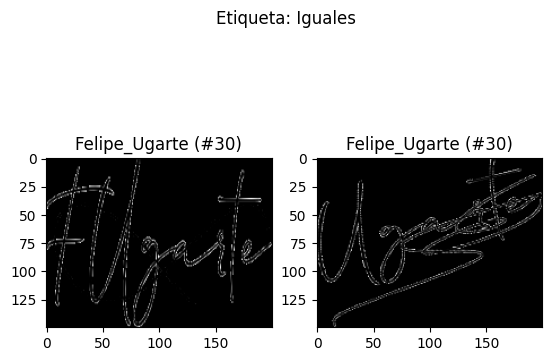

In [ ]:
data = load_dataset(DATASET_DIR)
pairs, labels, meta_info = generate_pairs(data)

X1 = np.array([pair[0] for pair in pairs])
X2 = np.array([pair[1] for pair in pairs])
y = np.array(labels)

# Mostrar ejemplo aleatorio
i = random.randint(0, len(X1) - 1)
show_pair(X1[i], X2[i], y[i], meta_info[i])

In [ ]:
pairs, labels, meta_info = generate_pairs(data)
X1 = np.array([pair[0] for pair in pairs])
X2 = np.array([pair[1] for pair in pairs])
y = np.array(labels)

In [ ]:
print(X1.shape)
print(X2.shape)

(200, 150, 200)
(200, 150, 200)


In [52]:
X1 = X1 / 255.0
X2 = X2 / 255.0


X1 = X1.reshape(-1, 200, 150, 200)
X2 = X2.reshape(-1, 200, 150, 200)


In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu

In [54]:
def build_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, (5,5), activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inputs, x)

input_shape = (200, 150, 200)  # Ajusta según tu tamaño real
base_network = build_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Distancia L1
l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
output = layers.Dense(1, activation='sigmoid')(l1_distance)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)
siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
siamese_model.summary()


print(f"Número de pares generados: {len(pairs)}")


print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200, 150,  │          0 │ -                 │
│ (InputLayer)        │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 200, 150,  │          0 │ -                 │
│ (InputLayer)        │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 128)       │ 27,919,168 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,919,297 (106.50 MB)

 Trainable params: 27,919,297 (106.50 MB)

 Non-trainable params: 0 (0.00 B)

Número de pares generados: 200
X1 shape: (1, 200, 150, 200), X2 shape: (1, 200, 150, 200), y shape: (200,)


In [55]:
print("Número de pares generados:", len(pairs))

Número de pares generados: 200


In [ ]:
siamese_model.fit([X1, X2], y, batch_size=10, epochs=10, validation_split=0.2)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1, 1
'y' sizes: 200
